<h4> Imports

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import networkx as nx
import sys
sys.path.append('../lib')
%matplotlib inline
import matplotlib

import venn

<h4>Data Preprocessing

In [122]:
#Loading data
df = pd.read_csv("../data/LoL_champions.csv")

In [123]:
#EDA
df.head()

,Name,Tags,Role,Range type,Resourse type,Base HP,HP per lvl,Base mana,Mana per lvl,Movement speed,...,Attack range,HP regeneration,HP regeneration per lvl,Mana regeneration,Mana regeneration per lvl,Attack damage,Attack damage per lvl,Attack speed per lvl,Attack speed,AS ratio
0,Aatrox,Fighter,Top,Melee,Blood Well,650,114,0,0.0,345,...,175,3.00,0.50,0.0,0.0,60,5.00,2.500,0.651,0.651
1,Ahri,"Mage,Assassin",Middle,Ranged,Mana,590,104,418,25.0,330,...,550,2.50,0.60,8.0,0.8,53,3.00,2.200,0.668,0.625
2,Akali,Assassin,"Top,Middle",Melee,Energy,600,119,200,0.0,345,...,125,9.00,0.90,50.0,0.0,62,3.30,3.200,0.625,0.625
3,Akshan,"Marksman,Assassin",Middle,Ranged,Mana,630,107,350,40.0,330,...,500,3.75,0.65,8.2,0.7,52,3.00,4.000,0.638,0.400
4,Alistar,"Tank,Support",Support,Melee,Mana,685,120,350,40.0,330,...,125,8.50,0.85,8.5,0.8,62,3.75,2.125,0.625,0.625


In [124]:
#Missing values
print(df.isna().any())


Name                         False
Tags                         False
Role                         False
Range type                   False
Resourse type                 True
Base HP                      False
HP per lvl                   False
Base mana                    False
Mana per lvl                 False
Movement speed               False
Base armor                   False
Armor per lvl                False
Base magic resistance        False
Magic resistance per lvl     False
Attack range                 False
HP regeneration              False
HP regeneration per lvl      False
Mana regeneration            False
Mana regeneration per lvl    False
Attack damage                False
Attack damage per lvl        False
Attack speed per lvl         False
Attack speed                 False
AS ratio                     False
dtype: bool


<h4> Data analysis

<h5> Role distribution

In [125]:
df["Role"].unique()


array(['Top', 'Middle', 'Top,Middle', 'Support', 'Jungle,Support',
       'Bottom', 'Bottom,Support', 'Jungle', 'Jungle,Support,Middle',
       'Top,Support', 'Jungle,Middle', 'Middle,Support',
       'Jungle,Top,Middle', 'Support,Top,Middle', 'Top,Jungle',
       'Middle,Support,Top', 'Top,Middle,Support', 'Support,Jungle',
       'Top,Support,Jungle,Middle', 'Jungle,Top', 'Bottom,Top,Middle',
       'Support,Middle', 'Middle,Top', 'Middle,Jungle',
       'Top,Jungle,Support', 'Bottom,Middle', 'Middle,Bottom,Top',
       'Bottom,Top', 'Top,Middle,Bottom', 'Jungle,Top,Support'],
      dtype=object)

In [126]:
role_dummies = df["Role"].str.get_dummies(sep=",")
role_dummies.head()

,Bottom,Jungle,Middle,Support,Top
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,1,0,1
3,0,0,1,0,0
4,0,0,0,1,0


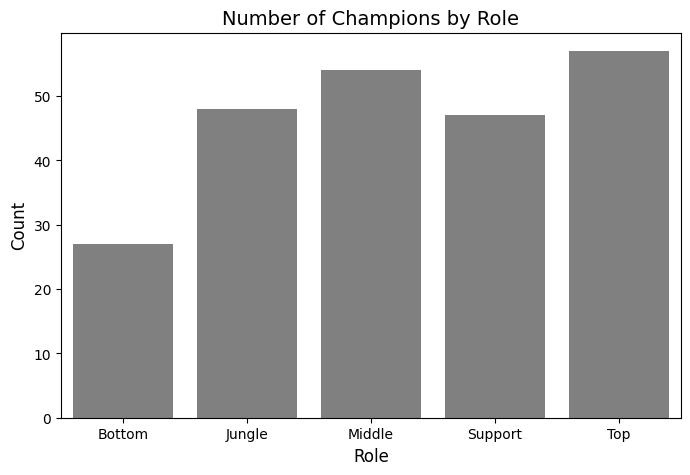

In [127]:
roles_count=role_dummies.sum()
roles_count.to_frame()
plt.figure(figsize=(8, 5))
sns.barplot(x=role_dummies.columns, y=roles_count, color="grey")
plt.title("Number of Champions by Role", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Role", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The sum of all counts is greater than the number of available champions. The cause is that some champions are assigned to more than one role.

In [155]:
multi_role_champs = df[df["Role"].str.contains(",", na=False)]
single_role_champs= df[~df["Role"].str.contains(",", na=False)]


Bottom     27
Jungle     48
Middle     54
Support    47
Top        57
dtype: int64

In [129]:
multi_role_champs['Role'] = df['Role'].str.split(',')
role_combinations = []
for roles in multi_role_champs['Role']:
    role_combinations.extend(combinations(sorted(roles), 2))


role_combinations_count = pd.Series(role_combinations).value_counts()
role_combinations_count_df = role_combinations_count.reset_index()
role_combinations_count_df.columns = ['Role Pair', 'Count']

role_combinations_count_df

C:\Users\trabk\AppData\Local\Temp\ipykernel_26712\3280976816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_role_champs['Role'] = df['Role'].str.split(',')


,Role Pair,Count
0,"(Middle, Top)",15
1,"(Middle, Support)",14
2,"(Jungle, Top)",13
3,"(Support, Top)",9
4,"(Jungle, Middle)",8
5,"(Jungle, Support)",7
6,"(Bottom, Middle)",5
7,"(Bottom, Support)",4
8,"(Bottom, Top)",4


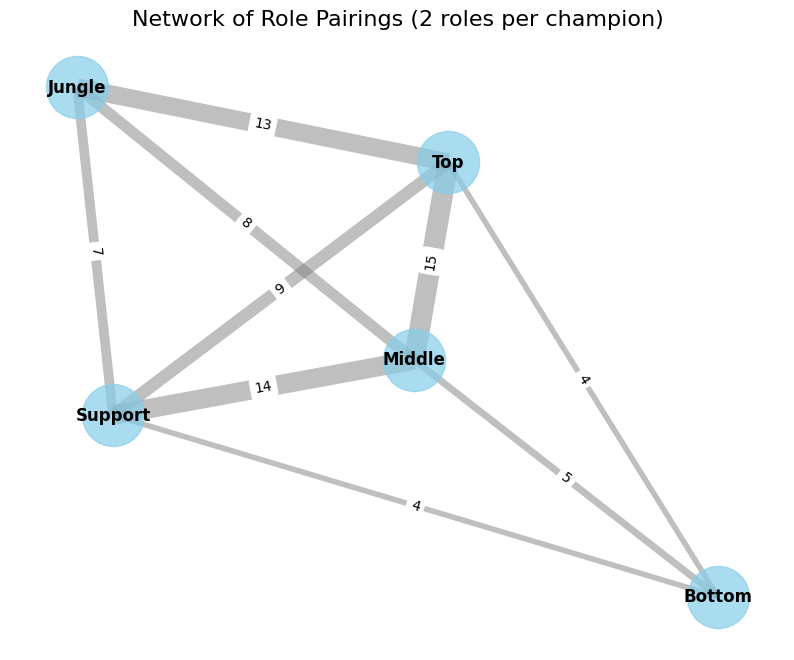

In [130]:

G = nx.Graph()

# Add nodes and edges to the graph based on role combinations
for _, row in role_combinations_count_df.iterrows():
    roles = row['Role Pair']  # This is already a tuple like ('Top', 'Middle') or ('Jungle', 'Support')

    for i in range(len(roles)):
        for j in range(i + 1, len(roles)):
            if G.has_edge(roles[i], roles[j]):
                G[roles[i]][roles[j]]['weight'] += row['Count']
            else:
                G.add_edge(roles[i], roles[j], weight=row['Count'])


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]


nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="skyblue", alpha=0.7)

nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.5, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
# Draw the labels for nodes and edges
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
plt.title("Network of Role Pairings (2 roles per champion)", fontsize=16)
plt.axis('off')
plt.show()

In [140]:

role_combinations3 = []
for roles in multi_role_champs['Role']:
    role_combinations3.extend(combinations(sorted(roles), 2))
    role_combinations3.extend(combinations(sorted(roles), 3))


role_combinations3_count = pd.Series(role_combinations3).value_counts()
role_combinations3_count_df = role_combinations3_count.reset_index()
role_combinations3_count_df.columns = ['Role Pair', 'Count']

single_role_counts = single_role_champs['Role'].value_counts()

all_roles_count = pd.concat([single_role_counts, role_combinations3_count])

In [146]:
roles_count_dict = all_roles_count.to_dict()

# Display the dictionary
print(roles_count_dict)

{'Top': 27, 'Jungle': 26, 'Middle': 22, 'Support': 21, 'Bottom': 17, ('Middle', 'Top'): 15, ('Middle', 'Support'): 14, ('Jungle', 'Top'): 13, ('Support', 'Top'): 9, ('Jungle', 'Middle'): 8, ('Jungle', 'Support'): 7, ('Bottom', 'Middle'): 5, ('Bottom', 'Support'): 4, ('Bottom', 'Top'): 4, ('Middle', 'Support', 'Top'): 4, ('Bottom', 'Middle', 'Top'): 3, ('Jungle', 'Support', 'Top'): 3, ('Jungle', 'Middle', 'Support'): 2, ('Jungle', 'Middle', 'Top'): 2}


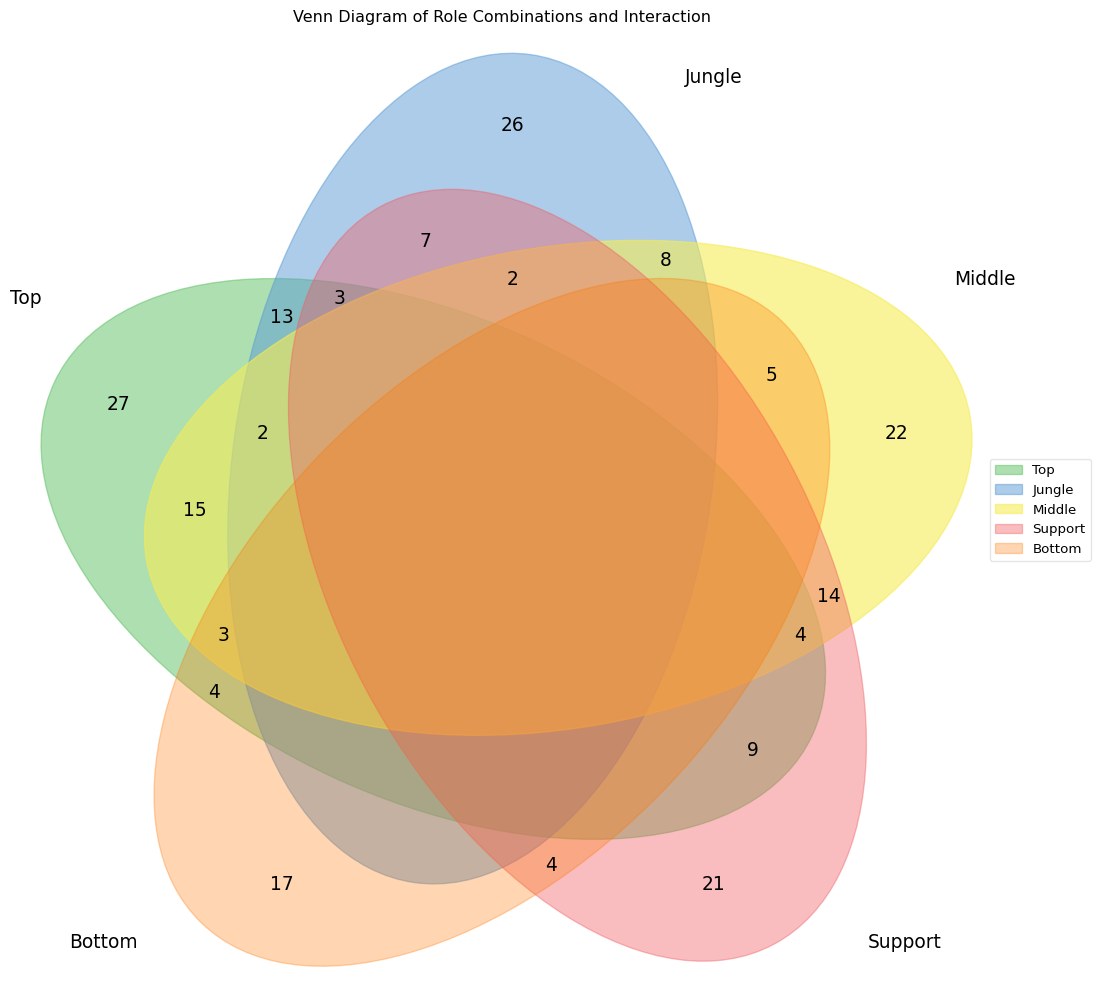

In [154]:
role_names = ['Top', 'Jungle', 'Middle', 'Support', 'Bottom']
# Helper function to convert role combinations into binary codes
def get_binary_code(roles):
    binary_code = ''.join(['1' if role in roles else '0' for role in role_names])
    return binary_code

labels = {}


for roles, count in roles_count_dict.items():
    binary_code = get_binary_code(roles)
    labels[binary_code] = str(count)
names = role_names

fig, ax = venn.venn5(labels, names=names)
plt.title("Venn Diagram of Role Combinations and Interaction")
plt.show()

* Many champions in League of Legends are not limited to just one role; they can fit into multiple positions depending on the team composition or strategy. For example, champions that can play both Middle and Top (or Jungle and Top) are highly versatile.
* Trios of roles are relatively rare, but some champions do fill the role of a multi-position hero, adding flexibility to a team's strategy.
* Out of the champions who can play the Support role, a large number are not confined to Support alone. In fact, only 17 champions are played solely as Support, while 30 champions can also fill Support alongside other roles. This suggests that Support champions are frequently designed with versatility in mind, often fulfilling additional roles such as Top, Middle, or Jungle.
